Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

%matplotlib inline

# Stochastic gradient Langevin dynamics, and uncertainty quantification

In this first part of the coursework you'll do two things:

* Implement stochastic gradient Langevin dynamics for sampling from a Bayesian neural network
* Break down the variance to estimate epistemic and aleatoric uncertainty

We're going to run this on the following toy 2D dataset, consisting of **two moons**, each a different class.

C:\Users\44774\AppData\Local\Temp\ipykernel_21996\2399861201.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset, validation_set = torch.load("two_moons.pt")


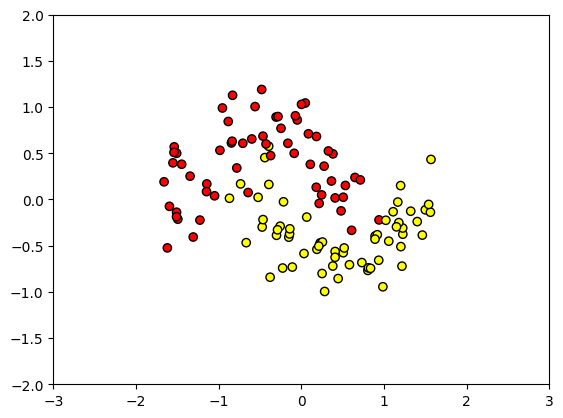

In [43]:
dataset, validation_set = torch.load("two_moons.pt") 
X_train, y_train = dataset.tensors
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.xlim(-3,3)
plt.ylim(-2,2)
# visualize the training data, should be two moon-shaped clusters

## We'll use the following simple feedforward network.

In [44]:
class TwoMoonsNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 100), # 2 input features, 100 output features
                        nn.ReLU(), # activation function is introduced after each layer to introduce non-linearity
                        nn.Linear(100, 10), # hidden layer i with 100 neurons and 10 output neurons
                        nn.ReLU(),
                        nn.Linear(10, 1)) # hideen layer 2 with 10 neurons and 1 output neuron
        
    def forward(self, x): # input X is a 2D tensor
        h = self.net(x) # forward pass through the network
        return torch.sigmoid(h).squeeze(1) # apply the sigmoid activation function, squash the output to range[0,1] for binary classification. squeeze(1) ensures the output is 1D
    
network = TwoMoonsNetwork()

# TASK 1 (5 points): Define the likelihood and the prior

Let $x_i \in \mathbb{R}^2$ denote an input, $y_i \in \{ 0, 1\}$ a target, and $\theta$ the network parameters.

Let $\hat y_i = f_\theta(x_i)$ denote the output of the network $f_\theta$.

You need to define:

* `log_likelihood`, evaluating a Bernoulli distribution $$\log p(y|x, \theta) = \log \mathrm{Bernoulli}(y | f_\theta(x));$$
* `log_prior`, evaluating a standard normal distribution $$\log p(\theta) = \log \mathcal{N}(\theta | 0, I).$$

Both of these functions should return a numeric scalar value.

For the prior, you will need to somehow access the parameters of the network! There are several ways of doing this. I suggest looking at the pytorch documentation for either

* iterating through `network.parameters()`, or
* using helper functions such as `nn.utils.parameters_to_vector`



In [45]:
def log_likelihood(network, X, y):
    """
    This function computes the log probability `log p(y | x, theta)`
    for a batch of inputs X.
    
    INPUT:
    network : instance of classifier network, extends `nn.Module`
    X       : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y       : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    
    OUTPUT:
    lp      : log probability value of log p(y | x, theta); scalar
    
    """
    # YOUR CODE HERE
    y_pred = network(X) 
    
    distribution = dist.Bernoulli(y_pred)
    
    return distribution.log_prob(y).sum()


In [46]:
# grading


In [47]:
def log_prior(network):
    # YOUR CODE HERE
    parameters = nn.utils.parameters_to_vector(network.parameters())
    
    distribution = dist.Normal(loc=0, scale=1) # loc: mean, scale: standard deviation
    
    return distribution.log_prob(parameters).sum()

In [48]:
# grading


In [49]:
# grading


# TASK 2 (3 points): Minibatching

Minibatching is "trickier" when we have a prior on the network parameters.

The function `log_joint_minibatch` should return a mini-batch estimate of the log joint of the full data, i.e. returning an estimator of $$\log p(\theta) + \sum_{i=1}^N \log p(y_i | x_i, \theta)$$ but which is evaluated on only the specified subset of the $N$ data points.

In [50]:
def log_joint_minibatch(network, X_batch, y_batch, N_training):
    """ Return a minibatch estimate of the full log joint probability 
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X_batch    : batch of inputs; torch.FloatTensor, matrix of shape = (batch_size, 2)
    y_batch    : batch of targets: torch.FloatTensor, vector of shape = (batch_size,)
    N_training : total number of training data instances in the full training set

    OUTPUT:
    lp : return an estimate of log p(y, theta | X), as computed on the batch; scalar.

    """
    # YOUR CODE HERE
    lp_prior = log_prior(network)
    lp_likelihood = log_likelihood(network, X_batch, y_batch)
    
    batch_size = X_batch.shape[0]
    lp_likelihood_scaled = lp_likelihood * N_training / batch_size
    
    return lp_prior + lp_likelihood_scaled

In [51]:
# grading


In [52]:
# grading


## Self-diagnostic

This is a small-enough dataset that we can compute the log joint probability on the whole dataset:

In [53]:
with torch.no_grad():
    full_data_lp = log_prior(network) + log_likelihood(network, X_train, y_train)
print("Full data log probability: %0.4f" % full_data_lp.item())

Full data log probability: -1325.1136


### In the next cell, we call `log_joint_minibatch`.

If all the code is working correctly, the minibatch estimates should be roughly normally-distributed around the true value!

Changing the batch size should not change the mean of this distribution. Try running the cell below several times.

If the histogram is far away from the true value (the black vertical dashed line), then you probably have a bug.

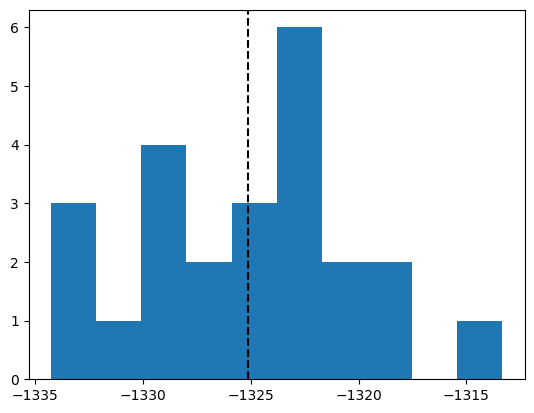

In [54]:
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5)

with torch.no_grad():
    batch_lp_est = [log_joint_minibatch(network, X, y, len(dataset)).item() for X, y in dataloader]
plt.hist(batch_lp_est, bins=10);
yl = plt.ylim()
plt.plot(full_data_lp.item()*np.ones(2), [0, plt.ylim()[1]], 'k--')
plt.ylim(yl);
# torch.stack(batch_lp_est).sum()

## Train the model (MAP estimation)

Run the following cell to train your model, to find a MAP estimate.

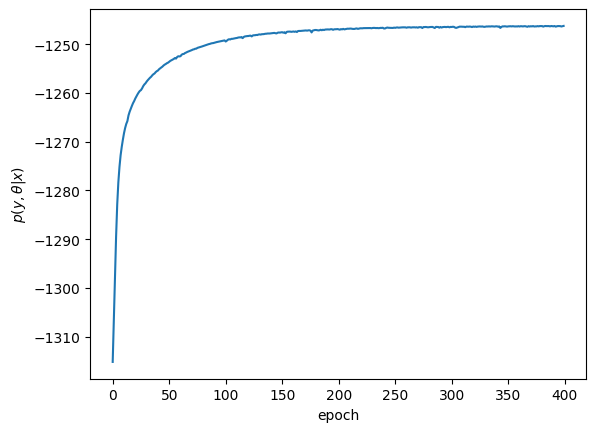

In [55]:
# train the neural network to find a MAP estimate for the model parameter theta.
dataloader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=5) # split the dataset into minibatches of size 5 
opt = torch.optim.Adam(network.parameters()) # use Adam optimizer to optimize the network parameters

N_epochs = 400
train_lp = []

for epoch in range(N_epochs):
    for X, y in dataloader: #for each minibatch
        opt.zero_grad() # zero the gradients
        loss = -log_joint_minibatch(network, X, y, len(dataset)) # compute the negative log joint probability as the loss 
        loss.backward() # backpropagate the gradients
        opt.step() # update the network parameters using the optimizer
    with torch.no_grad():
        train_lp.append((log_likelihood(network, X_train, y_train) + log_prior(network)).item()) # compute the log joint probability of the full training set
plt.plot(train_lp)
plt.xlabel("epoch")
plt.ylabel("$p(y, \\theta | x)$");

# when log joint converges, it means the MAP estimate has been found.
# 400 epochs mean the network is trained for 400 times, to repeatedly adjust its parameters to maximize the log joint probability.
# the theta* after 400 epochs is the MAP estimate.

## Confidence plot

To visualize the result, we'll look at a *confidence plot*.

The *confidence* is the probability assigned to whichever class is predicted.

If the most likely class is "yellow", then it shows $p(y = \text{yellow})$. If the most likely class is red, it shows $p(y = \text{red})$.



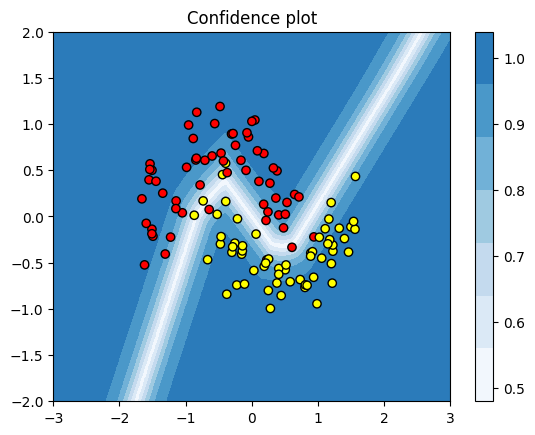

In [56]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    py = network(torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T))
    conf = torch.where(py > 0.5, py, 1-py) ## THIS LINE COMPUTES THE CONFIDENCE
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k')
plt.title("Confidence plot");
# dark blue: high confidence, light blue: low confidence. The decision boundary is where the confidence is 0.5

# Calibration and reliability diagrams

I've implemented a reliability diagram plot and expected calibration error computation here.

Could be interesting to see how the number of bins affects the result…!

In [57]:
def reliability_diagram(y, y_hat, N_bins=10):
    """
    Plot a reliability diagram
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    freq = [y[which_bin==k].mean().item() for k in range(N_bins)]
    conf = [y_hat[which_bin==k].mean().item() for k in range(N_bins)]
    plt.bar(bins[1]/2+np.arange(N_bins)/N_bins, freq, width=bins[1]*.9);
    plt.plot(conf, freq, 'o-', color='k')
    plt.plot([0, 1], [0, 1], '--', color='#333');

def expected_calibration_error(y, y_hat, N_bins=10):
    """
    Compute the expected calibration error
    """
    bins = torch.linspace(0, 1, N_bins+1)
    which_bin = (y_hat[:,None] >= bins[1:]).long().sum(-1).numpy()
    counts = []
    acc = []
    conf = []
    for k in range(N_bins):
        count = len(y[which_bin==k])
        if count > 0:
            acc.append(y[which_bin==k].mean().item())
            conf.append(y_hat[which_bin==k].mean().item())
        else:
            acc.append(0.0)
            conf.append(0.0)
        counts.append(count)
    return ((np.abs(np.array(acc) - np.array(conf))*np.array(counts))/len(y)).sum()

C:\Users\44774\AppData\Local\Temp\ipykernel_21996\3251367277.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.bar(bins[1]/2+np.arange(N_bins)/N_bins, freq, width=bins[1]*.9);


ECE = 0.0419


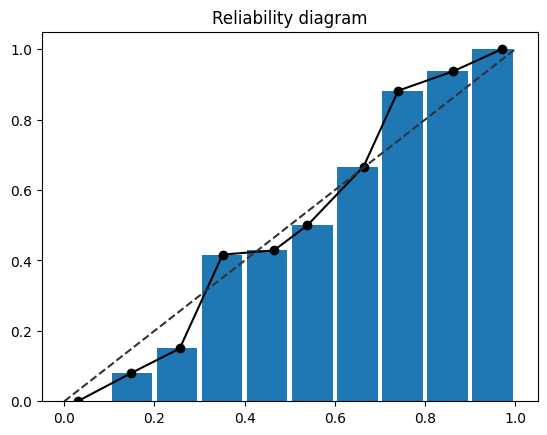

In [58]:
with torch.no_grad():
    y_hat = network(validation_set.tensors[0])

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))
plt.title("Reliability diagram");

# TASK 3 (6 points): stochastic gradient Langevin dynamics (SGLD)

In this task you can get

* 3 points for implementing the SGLD MCMC update
* 3 points for implementing Monte Carlo prediction

The `SGLD_step` function below should take a current set of network parameters $\theta$, and update them as

$$\theta' = \theta + \frac{\epsilon^2}{2} \nabla_\theta \log p(\theta, y | X) + \epsilon z$$

where $\epsilon$ is a learning rate, $X, y$ are a current mini-batch, and $z \sim \mathcal{N}(0, I)$ and has the same dimensionality as $\theta$.

For more details see the week 7 lecture slides!

Note that you will actually have to **do the update**. The following function does not return anything! Instead, it updates the parameters of the network, similar to how a `torch.optim` optimizer updates the parameters.

In [59]:
# SGLD samples from full posterior (instead of point estimate MAP) to estimate uncertainty in the predictions.
def SGLD_step(network, X, y, N_training, epsilon):
    """
    Run one step of SGLD given a mini-batch, and update the parameters of the network.
    
    INPUT:
    network    : instance of classifier network, extends `nn.Module`
    X          : batch of inputs; torch.FloatTensor, shape = (batch_size, 2)
    y          : batch of targets; torch.FloatTensor, shape = (batch_size,)
    N_training : total number of training data instances in the full training set
    epsilon    : step size / learning rate parameter (scalar)
    """
    
    noise = {}
    for idx, layer in enumerate(network.net): # iterate through layers in the network.net
        try:
            noise[f"layer_{idx}"] = epsilon * torch.randn_like(layer.weight) # for layer with weights, add noise to the SGLD update
        except AttributeError: # Skip layers without weights (e.g activation functions)
            continue

    log_joint = log_joint_minibatch(network, X, y, N_training)

    # ensure gradients from previous step do not accumulate 
    for param in network.parameters():
        if param.grad is not None:
            param.grad.zero_()

    # Backpropagation
    log_joint.backward()

    # SGLD update for layers explicitly
    with torch.no_grad():
        for idx, layer in enumerate(network.net):
            try:
                # Gradient update term
                grad_update = (epsilon**2 / 2) * layer.weight.grad
                # Add noise to the gradient update
                layer.weight.add_(grad_update + noise[f"layer_{idx}"])
            except AttributeError: # skip layers without weights
                continue

In [60]:
# grading


In [61]:
# grading


### Cyclic learning rate 

We're going to use a cyclic learning rate schedule for $\epsilon$, like discussed in the lectures. That function is pre-written, below.

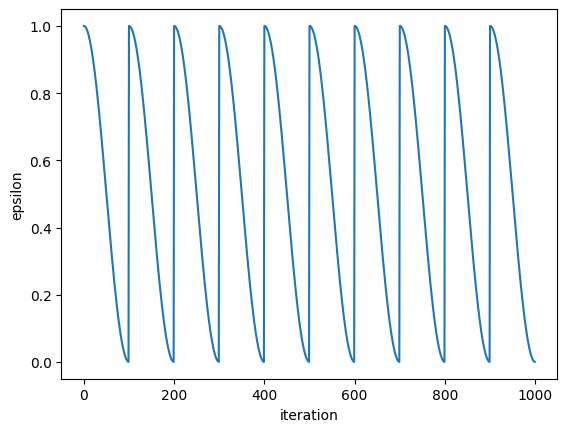

In [62]:
def learning_rate_schedule(N_steps, N_samples, epsilon):
    """
    Pre-compute a learning-rate schedule for SGLD.
    
    INPUT:
    N_steps   : number of SGD updates between each "reset"
    N_samples : number of times we reach the lowest target learning rate
    epsilon   : base learning rate
    
    OUTPUT:
    epsilon_t : vector of length N_steps*N_samples, containing epsilon_t at each iteration t
    """
    return epsilon * (np.cos(np.pi * (np.arange(N_samples*N_steps) % N_steps)/N_steps) + 1)

plt.plot(learning_rate_schedule(N_steps=100, N_samples=10, epsilon=0.5));
plt.xlabel("iteration");
plt.ylabel("epsilon");

### Running the sampler
The following function is also given: it will actually run the SGLD sampler, by calling your `SGLD_step` function above.

In [63]:
def draw_sgld_samples(network, N_samples, N_steps_per_sample, base_epsilon=0.02):
    """
    Draw samples using SGLD, following a prescribed learning rate schedule
    
    OUTPUT:
    samples : torch.FloatTensor, shape = (N_samples, "# of parameters in network")
    """
    lr_schedule = learning_rate_schedule(N_steps_per_sample, N_samples, base_epsilon)
    samples = []
    step = 0
    while True:
        for X, y in dataloader:
            SGLD_step(network, X, y, len(dataset), epsilon=lr_schedule[step])
            step += 1
            if step % N_steps_per_sample == 0:
                samples.append(nn.utils.parameters_to_vector(network.parameters()).detach())
            if step == len(lr_schedule):
                return torch.stack(samples)


In [64]:
samples = draw_sgld_samples(network, N_samples=50, N_steps_per_sample=200)
print("Tensor holding samples of theta has shape:", samples.shape)

Tensor holding samples of theta has shape: torch.Size([50, 1321])


## Making predictions

After running the sampler, you now have a `torch.FloatTensor` which contains many different sampled versions of the network parameters $s = 1,\dots,S$.

To make predictions on an input batch $X$, you will somehow need to "load" in the stored parameters, and run the forward pass using different $\theta^{(s)}$.

In [75]:
# use the posterior samples we got from SGLD to make predictions on a batch of input points X.
def predict_from_samples(X, network, samples):
    """
    Use posterior samples from SGLD to make predictions on input points.
    
    INPUT:
    X       : batch of input points; shape = (batch_size, 2)
    network : instance of classifier network, extends `nn.Module`
    samples : torch.FloatTensor containing samples of theta; shape = (num_samples, # of parameters)
    
    OUTPUT:
    y_hat_samples : torch.FloatTensor containing predictions; shape = (num_samples, batch_size)
    """

    y_hat_samples = []
    
    # Get layer weight shapes for splitting samples
    layer_shapes = [
        network.net[0].weight.size(),  
        network.net[0].bias.size(),   
        network.net[2].weight.size(), 
        network.net[2].bias.size(),   
        network.net[4].weight.size()  
    ]
    
    # Compute number of parameters per layer
    layer_sizes = [torch.prod(torch.tensor(shape)).item() for shape in layer_shapes]
    
    # Iterate over all posterior samples
    for theta in samples:
        # Initialize an index for slicing the parameter vector
        idx = 0
        
        # Extract weights and biases for each layer
        layer_params = []
        for size, shape in zip(layer_sizes, layer_shapes):
            # Slice, reshape, and append the parameters
            layer_params.append(theta[idx:idx + size].view(shape))
            idx += size
        
        # Load the parameters into the network
        with torch.no_grad():
            network.net[0].weight.copy_(layer_params[0])
            network.net[0].bias.copy_(layer_params[1])
            network.net[2].weight.copy_(layer_params[2])
            network.net[2].bias.copy_(layer_params[3])
            network.net[4].weight.copy_(layer_params[4])
        
        # Perform forward pass and store predictions
        y_hat_samples.append(network(X).detach())
    
    # Stack predictions into a tensor of shape (num_samples, batch_size)
    return torch.stack(y_hat_samples)


In [76]:
# The following should be true if your code is working!
assert predict_from_samples(X_train, network, samples).shape == (samples.shape[0], X_train.shape[0])

In [67]:
# grading


In [68]:
# grading


## Confidence plot and reliability diagrams for the Bayesian classifier

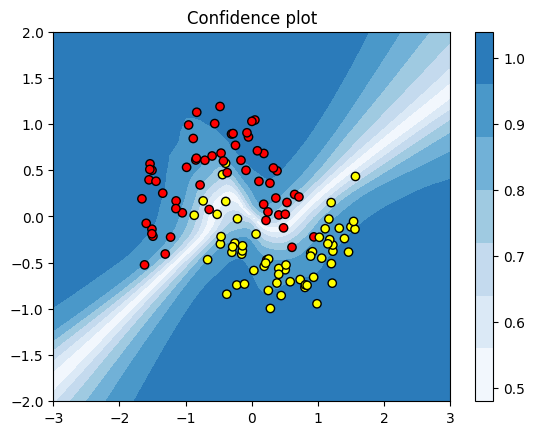

In [69]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-2, 2, 100))
with torch.no_grad():
    XXYY = torch.FloatTensor(np.stack((XX.ravel(), YY.ravel())).T)
    out = predict_from_samples(XXYY, network, samples)
    py = out.mean(0)
    conf = torch.where(py > 0.5, py, 1-py)
    ZZ = conf.reshape(XX.shape)
CS = plt.contourf(XX, YY, ZZ, cmap='Blues', vmin=0.5, vmax=1.2)
plt.colorbar(ticks=np.linspace(0.5, 1, 6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.title("Confidence plot");

ECE = 0.0489


C:\Users\44774\AppData\Local\Temp\ipykernel_21996\3251367277.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.bar(bins[1]/2+np.arange(N_bins)/N_bins, freq, width=bins[1]*.9);


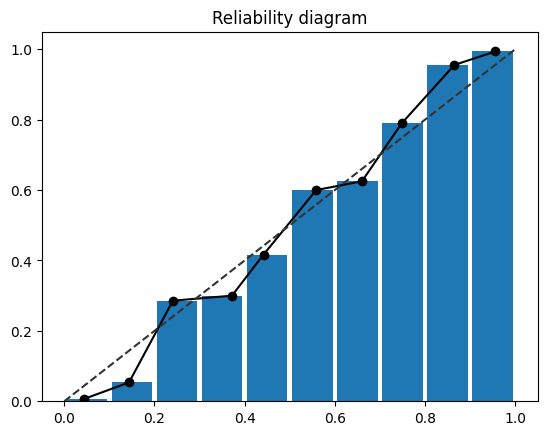

In [70]:
with torch.no_grad():
    y_hat = predict_from_samples(validation_set.tensors[0], network, samples).mean(0)

reliability_diagram(y=validation_set.tensors[1], y_hat=y_hat)
print("ECE = %0.4f" % expected_calibration_error(validation_set.tensors[1], y_hat))

plt.title("Reliability diagram");

## Uncertainty quantification

We can measure the uncertainty in our predictor by looking at the variance of the predictive distribution

$$p(y | \hat y).$$

Here, $\hat y$ is the posterior mean: the average $p(y = 1)$ estimated across all posterior samples.

The total predictive variance of $y$ is the variance of this distribution, i.e.

$$Var [ y | x ] = Var \left [ \int p(y | x, \theta)p(\theta | \mathcal{D}) d\theta \right]$$

One way to estimate epistemic and aleatoric uncertainty is to look at the variance of $\hat y$, i.e. the variance in $f_\theta(x)$ under the posterior over $\theta$. This corresponds to epistemic uncertainty. The difference between these two is then roughly the aleatoric uncertainty.

There are probably better ways to compute (and explain!) this, but hopefully the following plots look clear.

In [71]:
# Variance of predictive distribution over y
var_of_prediction = dist.Bernoulli(out.mean(0)).variance

# Epistemic uncertainty: Variance across values of y_hat
var_of_mean = out.var(0)

### Darker colors are more uncertain:

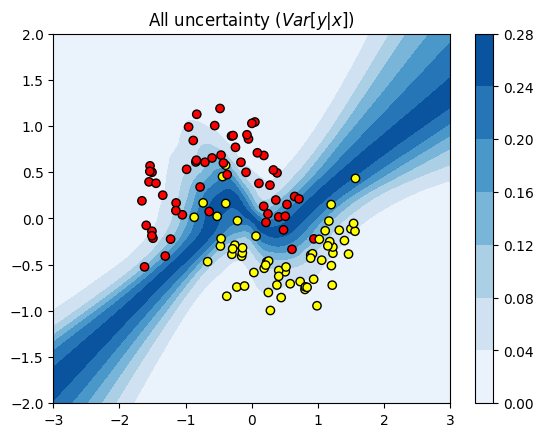

In [72]:
plt.title("All uncertainty ($Var[y | x]$)")
plt.contourf(XX, YY, var_of_prediction.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
plt.show()
# - torch.sigmoid(out).var(0).reshape(XX.shape))

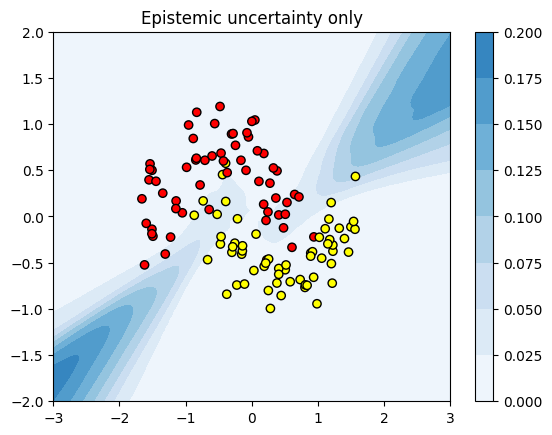

In [73]:
plt.title("Epistemic uncertainty only")
plt.contourf(XX, YY, var_of_mean.reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.28)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
# regions with low uncertatinty (light blue): network has seen similar data during training, high confidence in predictions (near decision boundary)
# regions with high uncertainty (dark blue): network has not seen similar data during training, low confidence in predictions (in the corners)

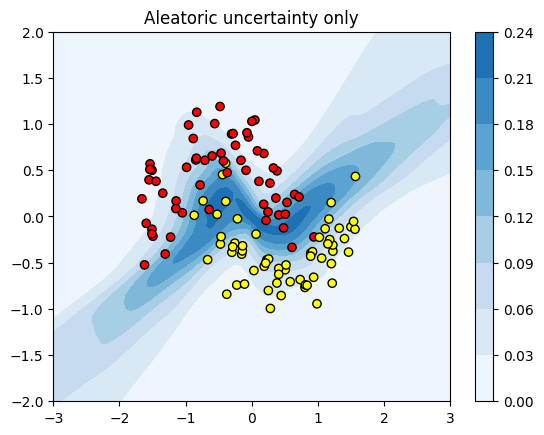

In [74]:
plt.title("Aleatoric uncertainty only")
plt.contourf(XX, YY, (var_of_prediction - var_of_mean).reshape(XX.shape), cmap='Blues', vmin=0, vmax=0.3)
plt.colorbar();
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='autumn', edgecolor='k');
# dark blue areas: classes overlap, oor data noise is high, uncertain
# light blue areas: data distribution is well-separated, low data noise, certain

# TASK 4 (up to 5 points, free response): Interpretation

Take a look at Figure 1 in the paper https://arxiv.org/pdf/2002.10118.pdf, "Being Bayesian, Even Just a Bit, Fixes Overconfidence in ReLU Networks", Kristiadi et al. 2020.

1. (4 points) Qualitatively, the uncertainty in figure 1 probably looks quite different from your plots in this notebook. Try to give two different reasons for why the results here might be different.
2. (1 point) What is going on with calibration / temperature scaling? Why doesn't the temperature scaling help in Figure 1 in the paper, and why doesn't the ECE improve in this case when we do sampling?

YOUR ANSWER HERE

### **Question 1**

The uncertainty in Figure for Bayesian all-layer from the paper and the plot in my notebook looks different:  In my plot, the model's confidence remains high far from the data (except near the decision boundary). The paper's method's confidence converges to 0.5 in regions far from the data. This could be due to two key reasons:

1. **Bayesian Approximation Method**:
   - In our implementation, **SGLD** is used to approximate the posterior distribution of the network parameters. SGLD directly samples from the full posterior but can produce uncertainty estimates that are noisy and sensitive to hyperparameters such as learning rate.
   - The paper uses **Laplace approximations** over the weights for all layers. Laplace assumes a Gaussian posterior around the MAP estimate, which results in smoother and more calibrated uncertainty estimates compared to SGLD.

2. **Model Architecture and Configuration**:
   - Our implementation uses a **shallow network** (e.g., two hidden layers with 100 and 10 neurons). While effective for simple tasks, this architecture may lack the capacity to model complex decision boundaries or accurately capture uncertainty in regions far from the training data.
   - The paper uses a **3-layer ReLU network with 20 hidden units in each layer** followed by a logistic output layer. This architecture:
     - Allows for more expressive decision boundaries due to additional depth and nonlinear transformations from ReLU activations.
     - Better captures epistemic uncertainty in areas with sparse training data, particularly when paired with Laplace approximations over the posterior.
   - The ReLU activations, as emphasized in the paper, lead to piecewise affine decision boundaries, which are smoothed and better calibrated by the Bayesian approximations (Laplace). This combination may explain why the paper's uncertainty visualizations are more refined and interpretable compared to those obtained with a shallower network.



### **Question 2**

1. **Calibration and Temperature Scaling**:
   - Temperature scaling adjusts the logits of a model (raw output before applying softmax or sigmoid) by dividing them by a scalar \( T \). This adjusts the confidence of the predicted probabilities, typically to reduce overconfidence.
   - However, temperature scaling does **not address the model's inability to capture uncertainty** due to the use of a MAP estimate, which focuses only on a single point estimate in the posterior. The lack of uncertainty information limits its effectiveness.

2. **Why ECE Doesn’t Improve with Sampling**:
   - Sampling from the posterior using techniques like SGLD introduces stochasticity and captures uncertainty. However:
     - If the posterior samples are poorly calibrated or not well-explored, the resulting predictions might still lack proper alignment with observed probabilities.
     - Without explicit calibration, such as temperature scaling or better posterior approximations, the Expected Calibration Error (ECE) is unlikely to improve significantly.

To summarize:
- Temperature scaling helps correct overconfident logits but does not incorporate the uncertainty information missing from MAP estimates.
- Sampling-based methods improve uncertainty estimation but may not directly improve calibration metrics like ECE unless combined with explicit calibration methods.
